In [1]:
%matplotlib inline

import numpy as np
from DMpy import DMModel, Parameter
from DMpy.learning import dual_lr_qlearning
from DMpy.observation import softmax
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('white')
import os

First we need to load some example outcomes from our experiment. This is a series of ones and zeros representing trials where the subject received a reward or did not receive a reward, and the likelihood of receiving this reward varies over the course of the task.

## Load the data

In [2]:
# Load the data
data_path = 'C:\Users\Toby\OneDrive - University College London\Scripts\DMpy_\Testing'
outcomes = np.loadtxt(os.path.join(data_path, 'example_outcomes.txt'))

print outcomes

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.
  1.  0.  0.  1.  1.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  0.  1.  1.  1.  0.  1.  1.  0.  0.  0.  1.  1.  0.  1.  1.  1.
  1.  1.  1.  1.  1.  0.  1.  1.  0.  0.  1.  0.  1.  0.  0.  0.  0.  1.
  0.  1.  1.  1.  1.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  1.  1.  1.  0.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  0.  0.  0.  0.  0.  1.
  1.  0.  1.  1.  1.  0.  0.  1.  1.  0.  0.  1.  1.  1.  1.  1.  0.  1.
  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.
  1.  0.  1.  1.  1.  0.  0.  1.  1.  1.  0.  1.  0.  1.  1.  0.  1.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  1.]


## Define parameters

Now we can set up our parameters (currently this needs to be done before simulating data which is a bit backwards).

For this we use the ``Parameter`` class in DMpy, which allows us to specify various arguments that determine how the parameter is estimated later on.

We're going to use a dual-learning rate Rescorla-Wagner model, which assumes that people learn at different rates from better than expected and worse than expected outcomes.

$$Q(t+1) = Q(t) + \begin{eqnarray*}
\alpha^{+}\delta(t)\ \ \ if\ \delta(t) > 0\\
\alpha^{-}\delta(t)\ \ \ if\ \delta(t) < 0
\end{eqnarray*}$$

The first parameter is the ``value`` parameter, which represents the value of the stimulus as estimated by the model (i.e. this should be highest when the subject sees lots of rewards associated with the stimulus). We're not attempting to estimate this parameter (although we could), so we specify its distribution as 'fixed' rather than giving it an actual distribution. We then specify the "mean" as 0.5, which just provides a starting value, and tell DMpy that it is a dynamic parameter (i.e. its value should fluctuate over the course of the experiment).

In [3]:
value = Parameter('value', 'fixed', mean=0.5, dynamic=True)

Next we'll define the alpha_p parameter - this is a learning rate parameter for positive outcomes (i.e. outcomes that are better than expected). For the sake of simplicity we'll also specify this as a fixed parameter, rather than trying to estimate it. Note that here we've not used the ``dynamic`` argument as this is a constant in the model.

In [4]:
alpha_p = Parameter('alpha_p', 'fixed', mean=0.3)

Now we can define the parameter we're interested in - alpha_n. Because we're going to estimate this parameter and want to incorporate a prior into this process, we need to provide some information about the distribution we expect this parameter's values to follow. Here we use a normal distribution with a mean of 0.5 and a variance of 0.1. This parameter should be between zero and one so we use the ``lower_bound`` and ``upper bound`` arguments to ensure this.

In [5]:
alpha_n = Parameter('alpha_n', 'normal', lower_bound=0, upper_bound=1, mean=0.5, variance=0.1)

Finally, the observation model we'll be using (the softmax model) has one parameter, beta. We'll leave this fixed at 3 for now.

In [6]:
beta = Parameter('beta', 'fixed', mean=3)

## Create the model

Now we've defined out parameters, we can put them into a model along with the functions we imported at the start that define the learning and observation models. For this we use the ``DMModel`` class. The arguments here are ``(learning model function, list of parameters for the learning model, observation model function, list of parameters for the observation model function)``.

In [7]:
model_dual_lr = DMModel(dual_lr_qlearning, [value, alpha_p, alpha_n], softmax, [beta])

## Define parameter values for simulation

We're doing to simulate data from a population where alpha_p is unimodally distributed but alpha_n is bimodally distributed - this is similar to what we might hypothesise to be the case in a study of healthy people and people with anxiety, both groups may learn similarly from rewards but anxious people might learn faster from punishments. 

To start off, we define a couple of variables specifying how many simulated subjects we want in each group.

In [8]:
n_groupA = 50
n_groupB = 50

For the alpha_p parameter, we'll generate some random values from a normal distribution with a mean of 0.3 and variance of 0.05.

In [9]:
alpha_p_values = np.random.normal(0.3, 0.05, n_groupA + n_groupB)

For alpha_n, we'll generate random values from two separate normal distributions, one with a mean of 0.3 and one with a mean of 0.7, and then join them together using numpy's concatenate function. This is somewhat like we might expect to see when comparing healthy individuals and patients with something like anxiety - given that we've recruited two (theoretically) distinct groups, if a particular parameter has some relevance to the disorder, we would expect its value to have a bimodal distribution.

In [10]:
alpha_n_values = np.concatenate([np.random.normal(0.3, 0.05, n_groupA), np.random.normal(0.7, 0.05, n_groupB)])

We can create a histogram of the resulting parameter distributions to see if they appear as they should.

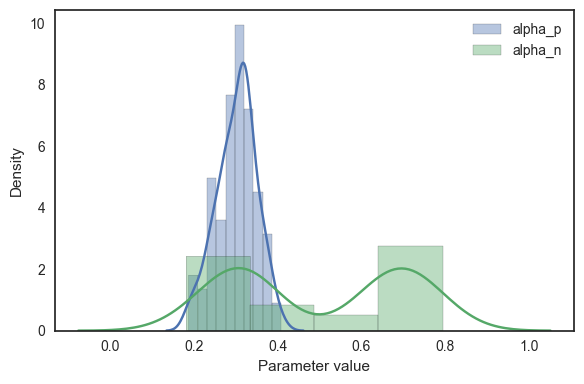

In [11]:
sns.distplot(alpha_p_values, label='alpha_p')
sns.distplot(alpha_n_values, label='alpha_n')
plt.legend()
plt.xlabel("Parameter value")
plt.ylabel("Density")
plt.tight_layout()

Now we've got the parameter values we want to use, we can plug them into our model and simulate some data. Here we use the ``simulate`` method of the model object we defined earlier. We tell it to use the outcomes that we loaded previously, and for the learning model parameters we use the alpha_p and alpha_n values we just defined, along with a list of 100 0.5s for the value parameter (this is the same for every subject). For the observation parameter beta, we give it a list of 100 3s. Finally, we provide a filename to save the output to.

The ``simulate`` method produces two outputs, and we don't really care about the first one here; this is why I've assigned the outputs to the variables ``_, sim_dual_lr`` - we use ``_`` in python to indicate a variable we don't want to use, it's just somewhere to put an unwanted output from a function. However, we do care about the second output (this is the saved results of the simulation) so we assign that to a proper variable called ``sim_dual_lr``. 

In [12]:
_, sim_dual_lr = model_dual_lr.simulate(outcomes=outcomes, 
                                     learning_parameters={'value': [0.5] * int(n_groupA + n_groupB),
                                                          'alpha_p': alpha_p_values,
                                                          'alpha_n': alpha_n_values},
                                     observation_parameters={'beta': [3] * int(n_groupA + n_groupB)},
                                     output_file=os.path.join(data_path, 'example_responses.txt'))

c:\users\toby\onedrive - university college london\dmpy\DMpy\model.py:815: Warning: Fewer outcome lists than simulated subjects, attempting to use same outcomes for each subject
  "subject", Warning)


Finished simulating
Saving simulated responses to C:\Users\Toby\OneDrive - University College London\Scripts\DMpy_\Testing\example_responses.txt


To illustrate how the simulated behaviour differs between our groups, we can visualise an example of the estimated value from a subject in each group.

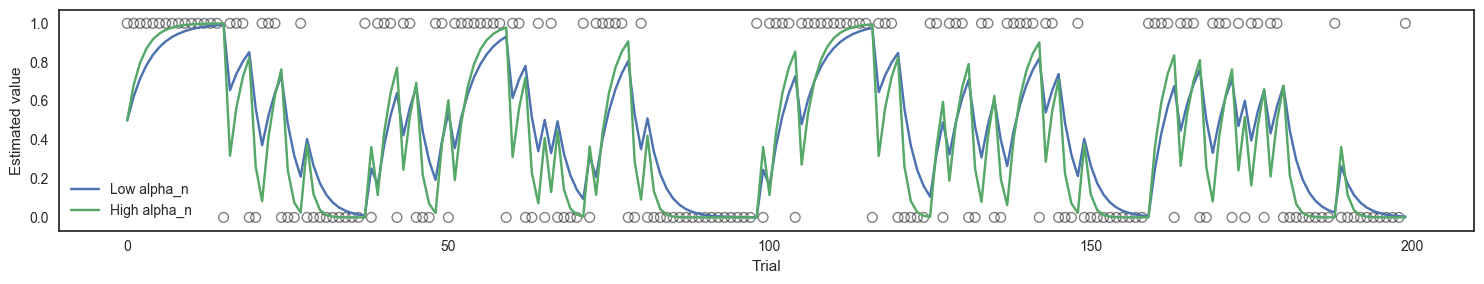

In [13]:
plt.figure(figsize=(15, 3))
plt.plot(model_dual_lr.simulated['sim_results']['value'][:, 0], label='Low alpha_n')
plt.plot(model_dual_lr.simulated['sim_results']['value'][:, n_groupA], label='High alpha_n')
plt.scatter(range(0, len(outcomes)), outcomes, facecolors='none', linewidths=1, color='black', alpha=0.5)
plt.legend()
plt.xlabel('Trial')
plt.ylabel('Estimated value')
plt.tight_layout()

## Fit the model

Finally, we need to try fitting our model to the data we've simulated - in theory the estimated parameter values should map neatly on to those which which we simulated the data. 

To do this, we use the ``fit`` method of the model we defined. We provide the location of the simulated data file we just generated, and some other arguments that determine how the model is fit. For the sake of time we'll use variational inference (http://docs.pymc.io/notebooks/api_quickstart.html#3.3-Variational-inference) with 30000 iterations, maximising the log likelihood (indicated using the ``logp_method`` argument). We'll tell it we want to estimate the model in a hierachical manner, and ask it to provide parameter recovery plots.

Loading multi-subject data with 100 subjects, 1 runs per subject
Loaded data, 100 subjects with 200 trials

-------------------Fitting model using ADVI-------------------

Performing hierarchical model fitting for 100 subjects


WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named mkl
Average Loss = 8,562.6: 100%|███████████████████████████████████████████████████| 30000/30000 [04:08<00:00, 120.51it/s]


Done

PARAMETER ESTIMATES

                                              Subject  mean_alpha_n  \
0   000_alpha_n.0.33931406088.alpha_p.0.2446832980...      0.302925   
1   001_alpha_n.0.29321397801.alpha_p.0.2444909544...      0.345701   
2   002_alpha_n.0.213817490822.alpha_p.0.286360543...      0.223773   
3   003_alpha_n.0.310597240143.alpha_p.0.319070734...      0.248879   
4   004_alpha_n.0.294592455358.alpha_p.0.317743107...      0.279043   
5   005_alpha_n.0.355911822069.alpha_p.0.322944316...      0.364427   
6   006_alpha_n.0.323181621184.alpha_p.0.310818482...      0.323647   
7   007_alpha_n.0.305818986659.alpha_p.0.333507167...      0.325753   
8   008_alpha_n.0.320516777369.alpha_p.0.324892620...      0.344357   
9   009_alpha_n.0.332831217739.alpha_p.0.350985746...      0.279513   
10  010_alpha_n.0.323801191783.alpha_p.0.221219799...      0.360946   
11  011_alpha_n.0.301475518463.alpha_p.0.297752374...      0.309772   
12  012_alpha_n.0.296760608826.alpha_p.0.322999499

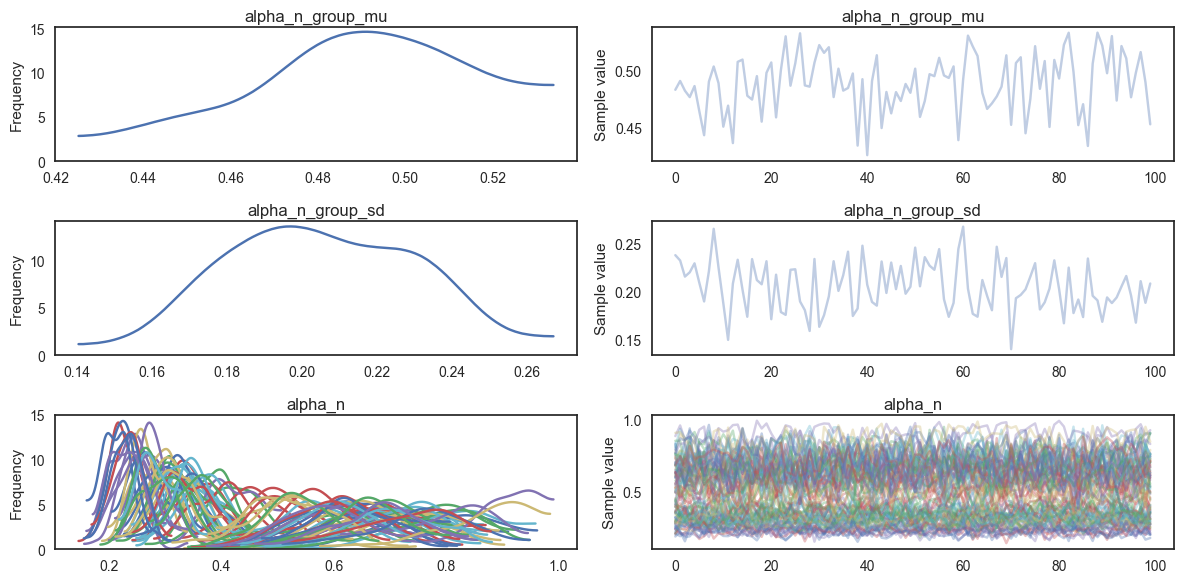

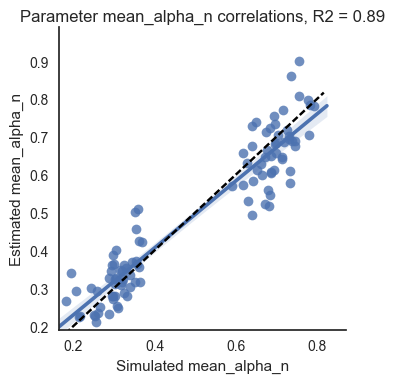

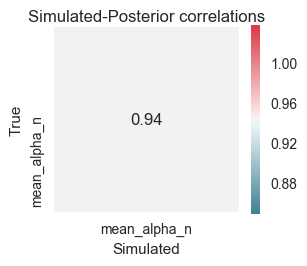

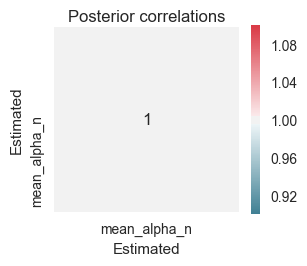

In [14]:
model_dual_lr.fit(sim_dual_lr, fit_method='variational', fit_kwargs=dict(n=30000), logp_method='ll', hierarchical=True,
                    recovery=True)

On the whole, this has worked pretty well - the correlation between the simulated and recovered parameters is .94 and the R<sup>2</sup> value is .89. However there are a couple of problems - firstly, the group level SD is large (0.2) which means we're losing some of the benefit of hierarchical estimation methods (this method uses the group-level distribution to constrain the individual subject estimates; a wide group-level distribution isn't going to constrain these estimates much). Secondly, our individual subject estimates have been drawn slightly towards the group mean. This can be seen in the correlation plot - the black dotted line is the line of equality (simulated value = recovered value) and the fitted line in blue is slightly flatter than this, indicating that higher values have been underestimated while lower values have been overestimated.